# Vehicle Detection Project
In this project, your goal is to write a software pipeline to detect vehicles in a video.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
%matplotlib inline
from sklearn.cross_validation import train_test_split
import lesson_functions
from lesson_functions import *

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Make a list of vehicle images


In [2]:
vehicle_images = glob.glob('vehicles/*/*.png',recursive=True)
non_vehicle_images = glob.glob('non-vehicles/*/*.png',recursive=True)
print(len(vehicle_images))
print(len(non_vehicle_images))
test_images = glob.glob('test_images/*.jpg')

8792
8968


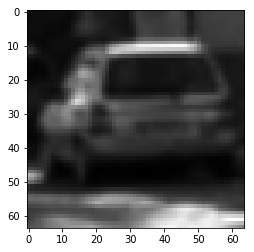

In [3]:
# Create the labels (car:1, non-car:0)
y_all = np.ones(len(vehicle_images))
y_all = np.append(y_all,np.zeros(len(non_vehicle_images)))
images = np.append(vehicle_images,non_vehicle_images)

#randomly select an index as sample among the images
# for i in range(2):
ind = np.random.randint(0, y_all.shape[0])
image = mpimg.imread(images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')
plt.figure()


Define the `get_hog_features`

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


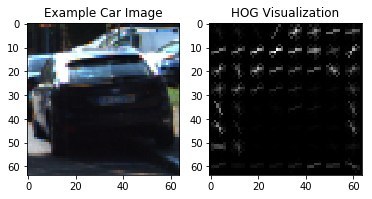

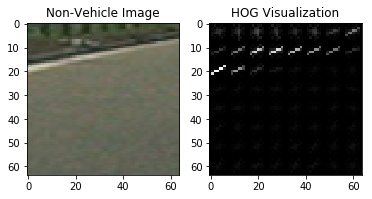

In [5]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2


ind = np.random.randint(0, len(vehicle_images))
image = mpimg.imread(vehicle_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

ind = np.random.randint(0, len(non_vehicle_images))
image = mpimg.imread(non_vehicle_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# This sample is using grayscale image
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Non-Vehicle Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, y_all, test_size=0.30, random_state=50)

In [7]:
print('test: car %d' % (len(vehicle_images) - y_train.sum() ))
print('test: non-car %d' % (len(y_test) - (len(vehicle_images) - y_train.sum()) ))

test: car 2641
test: non-car 2687


In [8]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if vis==False:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
        else:

            hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
            return np.concatenate(img_features),hog_image
            

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Try different color space

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


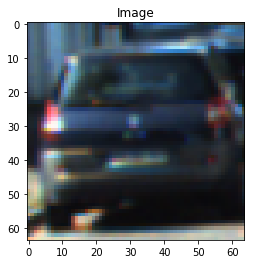

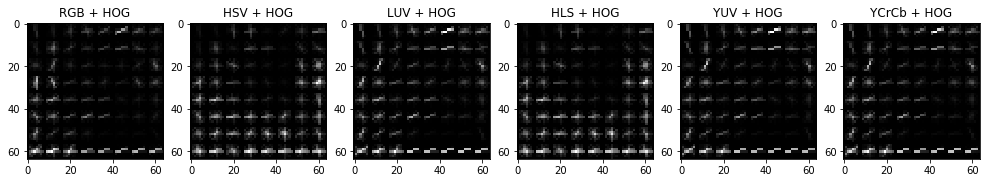

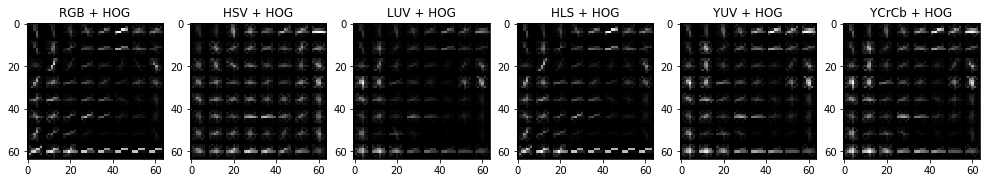

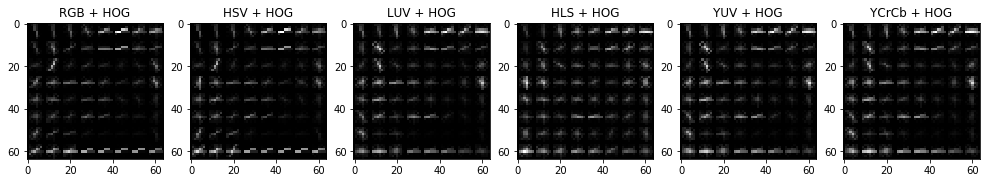

In [9]:
ind = np.random.randint(0, len(images))
test_img = mpimg.imread(images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# This sample is using grayscale image
# features, hog_image = get_hog_features(gray, orient, 
#                         pix_per_cell, cell_per_block, 
#                         vis=True, feature_vec=False)


# Plot the examples
# fig =plt.figure(figsize=(20, 10)) 
plt.imshow(test_img, cmap='gray')
plt.title('Image')

for i in range(3):
    
    plt.figure(figsize=(20, 10)) 

    plt.subplot(171)
    features,hog_image = single_img_features(test_img, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=16, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.imshow(hog_image, cmap='gray')
    plt.title('RGB + HOG')

    plt.subplot(172)
    features,hog_image = single_img_features(test_img, color_space='HSV', spatial_size=(32, 32),
                            hist_bins=32, orient=16, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HSV + HOG')
    features,hog_image = single_img_features(test_img, color_space='LUV', spatial_size=(32, 32),
                            hist_bins=32, orient=16, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.subplot(173)
    plt.imshow(hog_image, cmap='gray')
    plt.title('LUV + HOG')

    features,hog_image = single_img_features(test_img, color_space='HLS', spatial_size=(32, 32),
                            hist_bins=32, orient=16, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.subplot(174)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HLS + HOG')

    features,hog_image = single_img_features(test_img, color_space='YUV', spatial_size=(32, 32),
                            hist_bins=32, orient=16, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.subplot(175)
    plt.imshow(hog_image, cmap='gray')
    plt.title('YUV + HOG')


    features,hog_image = single_img_features(test_img, color_space='YCrCb', spatial_size=(32, 32),
                            hist_bins=32, orient=16, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.subplot(176)
    plt.imshow(hog_image, cmap='gray')
    plt.title('YCrCb + HOG')

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


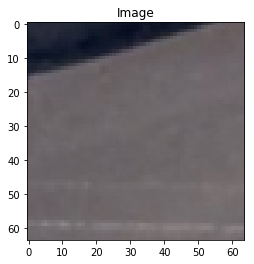

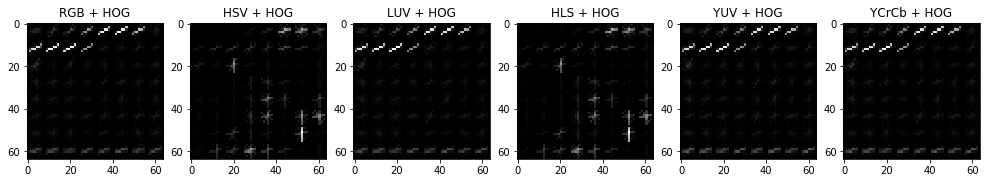

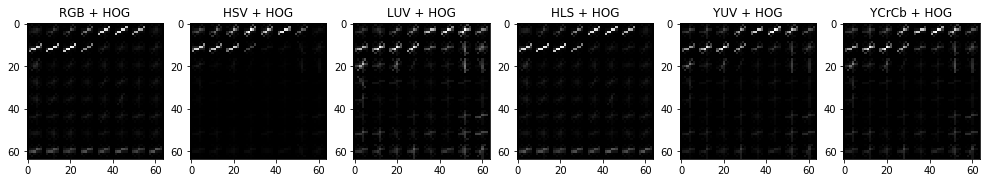

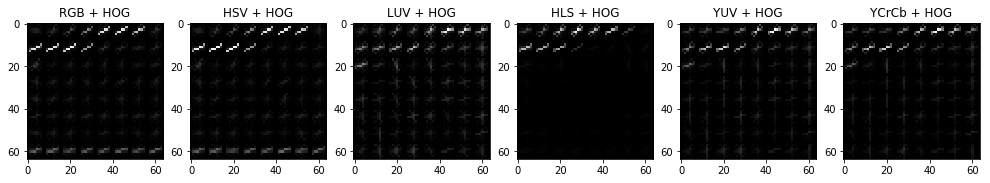

In [10]:
ind = np.random.randint(0, len(images))
test_img = mpimg.imread(images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# This sample is using grayscale image
# features, hog_image = get_hog_features(gray, orient, 
#                         pix_per_cell, cell_per_block, 
#                         vis=True, feature_vec=False)


# Plot the examples
# fig =plt.figure(figsize=(20, 10)) 
plt.imshow(test_img, cmap='gray')
plt.title('Image')

for i in range(3):
    
    plt.figure(figsize=(20, 10)) 

    plt.subplot(171)
    features,hog_image = single_img_features(test_img, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.imshow(hog_image, cmap='gray')
    plt.title('RGB + HOG')

    plt.subplot(172)
    features,hog_image = single_img_features(test_img, color_space='HSV', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HSV + HOG')
    features,hog_image = single_img_features(test_img, color_space='LUV', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.subplot(173)
    plt.imshow(hog_image, cmap='gray')
    plt.title('LUV + HOG')

    features,hog_image = single_img_features(test_img, color_space='HLS', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.subplot(174)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HLS + HOG')

    features,hog_image = single_img_features(test_img, color_space='YUV', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.subplot(175)
    plt.imshow(hog_image, cmap='gray')
    plt.title('YUV + HOG')


    features,hog_image = single_img_features(test_img, color_space='YCrCb', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=i,
                        spatial_feat=False, 
                        hist_feat=False, hog_feat=True,vis=True)
    plt.subplot(176)
    plt.imshow(hog_image, cmap='gray')
    plt.title('YCrCb + HOG')

## HOG Classify

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from lesson_functions import *

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, cspace='RGB', orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif cspace == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image = np.copy(image)      

#         # Call get_hog_features() with vis=False, feature_vec=True
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))
#             hog_features = np.ravel(hog_features)        
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         # Append the new feature vector to the features list
#         features.append(hog_features)
#     # Return list of feature vectors
#     return features


cars = vehicle_images
notcars = non_vehicle_images

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


51.43 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4736
17.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9727
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
0.0021 Seconds to predict 10 labels with SVC


### This is the image feature extraction used in training, testing, and prediction

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import lesson_functions
from lesson_functions import *

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='HLS', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=11, 
                    pix_per_cell=6, cell_per_block=2, 
                    hog_channel=0, spatial_feat=False, 
                    hist_feat=False, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    

In [13]:
#timtemp 1

In [18]:

### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [None, None] # Min and max in y to search in slide_window()
y_start_stop = [400, None] # Min and max in y to search in slide_window()

In [21]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

X_train_temp, X_test_temp, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100)

X_scaler = StandardScaler().fit(X_train_temp)

X_train = X_scaler.transform(X_train_temp)
X_test = X_scaler.transform(X_test_temp)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# param_grid = {}
svc = LinearSVC(C=0.01)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5520
13.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9913


/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


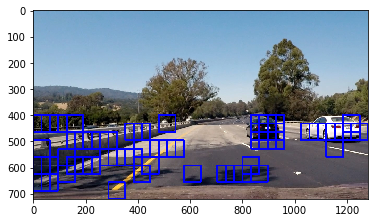

In [19]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [17]:
from sklearn.externals import joblib
joblib.dump(svc, 'dump_svc.pkl') 
joblib.dump(X_scaler, 'dump_scaler.pkl') 

['dump_scaler.pkl']

In [14]:
from sklearn.externals import joblib
svc = joblib.load('dump_svc.pkl')
X_scaler = joblib.load('dump_scaler.pkl')



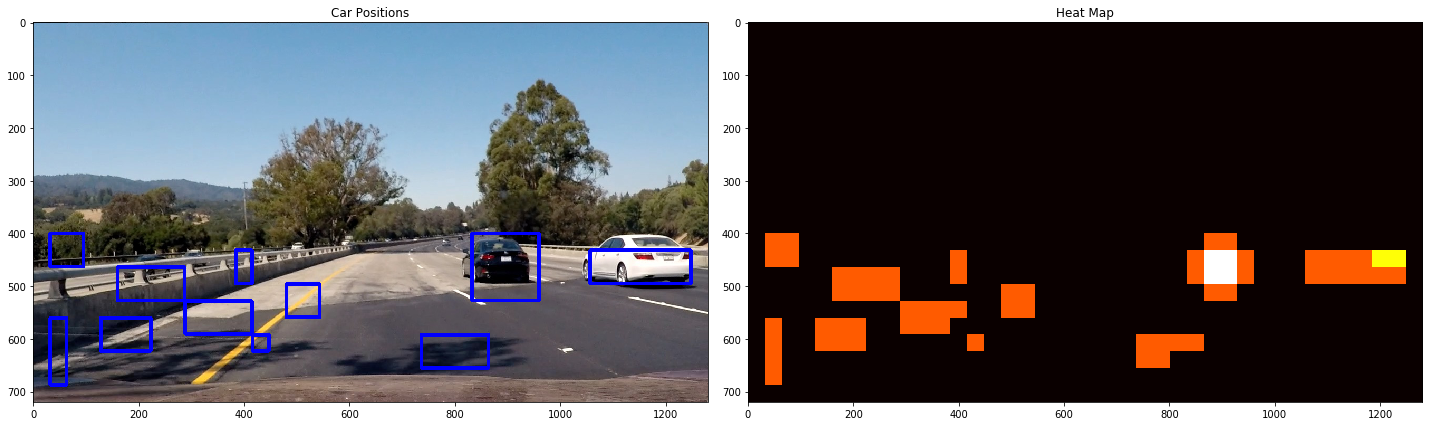

In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))
box_list = hot_windows

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels,boxcolor=(0,0,255)):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], boxcolor, 6)
    # Return the image
    return img


# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


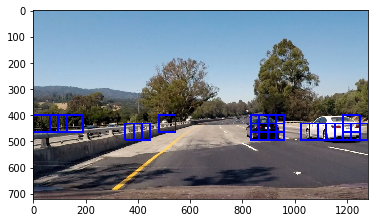

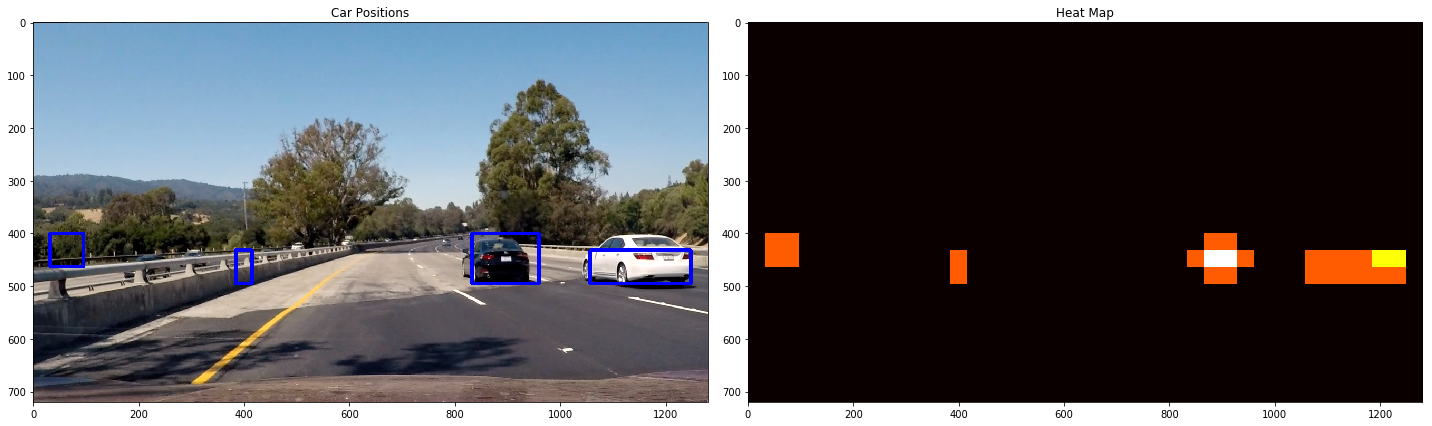

In [20]:

image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
y_start_stop = [400, 500] # Min and max in y to search in slide_window()


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

box_list = hot_windows

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


# def pipeline_detect_car(input_image):
#     windows = slide_window(image=input_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


NameError: name 'add_heat' is not defined

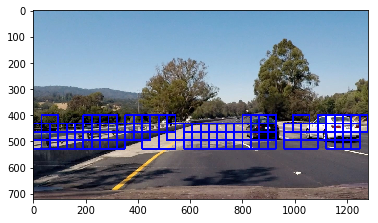

In [18]:

image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
y_start_stop = [400, 550] # Min and max in y to search in slide_window()


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

box_list = hot_windows

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

y_start_stop = [500, None] # Min and max in y to search in slide_window()


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    


# def pipeline_detect_car(input_image):
#     windows = slide_window(image=input_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


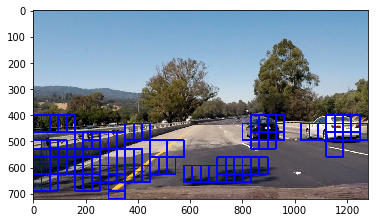

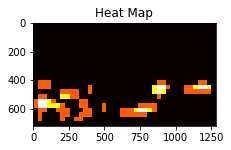

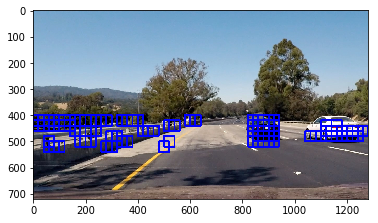

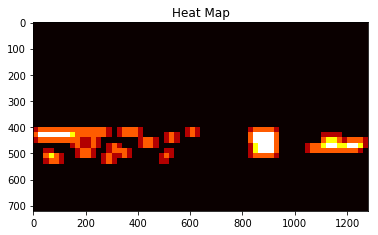

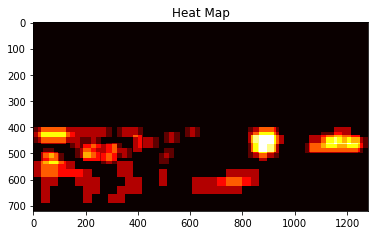

In [22]:

image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
y_start_stop = [400, None] # Min and max in y to search in slide_window()


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

box_list = hot_windows

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
# plt.imshow(draw_img)
# plt.title('Car Positions')
# plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
y_start_stop = [400, 550] # Min and max in y to search in slide_window()


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(40, 40), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.figure()
# plt.subplot(122)
plt.imshow(window_img)

box_list = hot_windows

# heat_combine = add_heat(heat,box_list)
heat_combine = heat
# # Read in image similar to one shown above 
# image = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)

heat_combine += heat
# # Apply threshold to help remove false positives
# heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(image), labels)

# fig = plt.figure(figsize=(20, 10))
plt.figure()
# plt.subplot(121)
# plt.imshow(draw_img)
# plt.title('Car Positions')
# plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


# heat_combine = apply_threshold(heat_combine,1)
heatmap_all = np.clip(heat_combine, 0, 255)

plt.figure()
plt.imshow(heatmap_all, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [25]:


def generate_heatmap(input_image, y_start_stop = [400, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5),
                    threshold_flag=False,
                    color_space='HLS', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=11, 
                    pix_per_cell=6, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True,
                    scaler=X_scaler, clf=svc):
#     image = mpimg.imread('test_images/test4.jpg')
    draw_image = np.copy(input_image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows = slide_window(input_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows(image, windows, clf, scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    #     the image with boxes
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return window_img,heat

# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5))

# hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# plt.imshow(window_img)

# box_list = hot_windows

def process_heatmap (input_image,input_heatmap, y_start_stop = [400, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5),threshold_flag=True):
    temp_img,temp_heatmap = generate_heatmap(input_image=input_image,
                                             y_start_stop=y_start_stop,
                                             xy_window=xy_window,
                                             xy_overlap=xy_overlap,
                                             threshold_flag=threshold_flag)
    

    temp_heatmap += input_heatmap
    return temp_img, temp_heatmap

/Users/ts186045/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


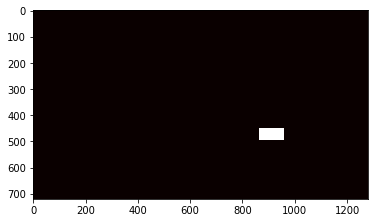

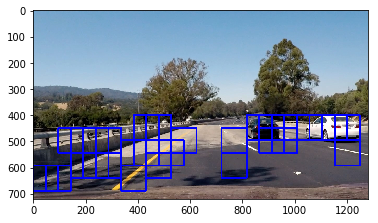

In [37]:
# y_start_stop = [400, None]
xy_window=(96, 96)
xy_overlap=(0.5, 0.5)
threshold_flag=False
# hist_range=(0, 256)
scaler=X_scaler
clf=svc
### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [None, None] # Min and max in y to search in slide_window()
y_start_stop = [400, None] # Min and max in y to search in slide_window()

input_img = mpimg.imread('test_images/test4.jpg')

draw_image = np.copy(input_img)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(input_img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap)

hot_windows = search_windows(image, windows, clf, scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

#     the image with boxes
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

box_list = hot_windows

# Read in image similar to one shown above 
heat = np.zeros_like(input_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# labels_car,temp_img = pipeline_car_tracking(input_img)
plt.figure()
plt.imshow(heatmap, cmap='hot')
# plt.imshow(temp_img)
plt.figure()
plt.imshow(window_img)

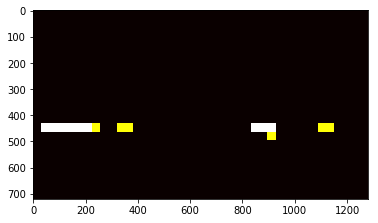

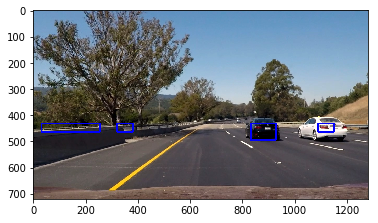

In [25]:
###### make sure training conf is same as method conf
# xy_overlap=(0.5, 0.5)
# threshold_flag=False
# # hist_range=(0, 256)
# scaler=X_scaler
# clf=svc
# ### TODO: Tweak these parameters and see how the results change.
# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 11  # HOG orientations
# pix_per_cell = 6 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins = 16    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# # y_start_stop = [None, None] # Min and max in y to search in slide_window()
# y_start_stop = [400, None] # Min and max in y to search in slide_window()

def generate_heatmap(input_image, y_start_stop = [400, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5),
                    threshold_flag=False,
                    color_space='HLS', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=11, 
                    pix_per_cell=6, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True,
                    scaler=X_scaler, clf=svc):
    #     image = mpimg.imread('test_images/test4.jpg')
    draw_image = np.copy(input_image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # image = image.astype(np.float32)/255
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    
    return draw_img,heat



input_img = mpimg.imread('test_images/test6.jpg')
drawn_img,heatmap_img = generate_heatmap(input_image=input_img, y_start_stop = [400, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5),
                    threshold_flag=True,
                    color_space='HLS', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True,
                    scaler=X_scaler, clf=svc)
plt.figure()
plt.imshow(heatmap_img, cmap='hot')

# plt.figure()
# plt.imshow(labels, cmap='hot')
# plt.imshow(temp_img)
plt.figure()
plt.imshow(drawn_img)

In [107]:
def process_heatmap (input_image,input_heatmap, y_start_stop = [400, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5),threshold_flag=True):
    temp_img,temp_heatmap = generate_heatmap(input_image=input_image,
                                             y_start_stop=y_start_stop,
                                             xy_window=xy_window,
                                             xy_overlap=xy_overlap,
                                             threshold_flag=threshold_flag)
    

    temp_heatmap += input_heatmap
    return temp_img, temp_heatmap

### Test on Video

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

In [ ]:
#instantiate the lane_container object
sample_output = 'video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

In [ ]:
###### make sure training conf is same as method conf
# xy_overlap=(0.5, 0.5)
# threshold_flag=False
# # hist_range=(0, 256)
# scaler=X_scaler
# clf=svc
# ### TODO: Tweak these parameters and see how the results change.
# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 11  # HOG orientations
# pix_per_cell = 6 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins = 16    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# # y_start_stop = [None, None] # Min and max in y to search in slide_window()
# y_start_stop = [400, None] # Min and max in y to search in slide_window()

def pipeline_detect(input_image, y_start_stop = [400, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5),
                    threshold_flag=False,
                    color_space='HLS', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=11, 
                    pix_per_cell=6, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True,
                    scaler=X_scaler, clf=svc,
                    debug_mode='off'):
    #     image = mpimg.imread('test_images/test4.jpg')
    draw_image = np.copy(input_image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # image = image.astype(np.float32)/255
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[350, 500], 
                        xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    if (debug_mode=='debug'):
        plt.figure()
        plt.title('Example [400 550], scale = 1')

        plt.imshow(draw_img)
    
    heatmap1 = heat
    
    
    #iterate 2
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[350, 550], 
                        xy_window=[int(float(xy_window[0]) * 1.2) , int(float(xy_window[1]*1.2))] , xy_overlap=xy_overlap)

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    if (debug_mode=='debug'):
        print(int(float(xy_window[0]) * 1.2))
        plt.figure()
        plt.imshow(draw_img)
        plt.title('Example [400 600], scale = 1.2')

    heatmap2 = heat

    
    
    #iterate 3
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                            xy_window = [int(float(xy_window[0]) * 1.6) , int(float(xy_window[1]*1.6))]
                           , xy_overlap=xy_overlap)

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    if (debug_mode=='debug'):
        print( int(float(xy_window[0]) * 1.6))
        plt.figure()
        plt.imshow(draw_img)
        plt.title('Example [500 650], scale = 1.6')

    heatmap3 = heat

    
    
    
    #iterate 4
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[450, 550], 
                        xy_window=[int(float(xy_window[0]) * 2.2) , int(float(xy_window[1]*2.2))]  , xy_overlap=xy_overlap)

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    if (debug_mode=='debug'):
        print(int(float(xy_window[0]) * 2.2))
        plt.figure()
        plt.imshow(draw_img)
        plt.title('Example [450 650], scale = 2.2')

    heatmap4 = heat
    

    
    #iterate 5
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[450, 650], 
                        xy_window=[xy_window[0] * 3, xy_window[1]*3]  , xy_overlap=xy_overlap)

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    if (debug_mode=='debug'):
        print([xy_window[0] * 3, xy_window[1]*3])
        plt.figure()
        plt.imshow(draw_img)
        plt.title('Example [450 650], scale = 3')

    heatmap5 = heat    

    heat = heatmap1 + heatmap2 + heatmap3 +  heatmap4 + heatmap4
    heat = apply_threshold(heat,3)

    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)



    return draw_img,heat, labels

In [ ]:
for i in range(0,len(test_images)):
    print(test_images[i])
    input_img = mpimg.imread(test_images[i])
    drawn_img,heatmap_img,labels = pipeline_detect(input_image=input_img, y_start_stop = [400, None],
                        xy_window=(64, 64), xy_overlap=(0.8, 0.8),
                        threshold_flag=True,
                        color_space='HLS', 
                        spatial_size=(16, 16), hist_bins=16, 
                        hist_range=(0, 256), orient=8, 
                        pix_per_cell=8, cell_per_block=2, 
                        hog_channel='ALL', spatial_feat=True, 
                        hist_feat=True, hog_feat=True,
                        scaler=X_scaler, clf=svc,
                        debug_mode='debug')
    plt.figure()
    plt.imshow(heatmap_img, cmap='hot')

    # plt.figure()
    # plt.imshow(labels, cmap='hot')
    # plt.imshow(temp_img)
    plt.figure()
    plt.imshow(drawn_img)
    plt.title('combined')

In [160]:
class VDetector():
    def __init__(self):
        self.out_image = None
        # transformation matrix, will be used for birds-eye-view transformation
        self.svc = svc
        # inverse transformation matrix, will be used for transforming lanes from birds-eye-view to normal view
        self.xscaler = X_scaler
        # the current unprocessed image
        self.heatmaps=[]
        
        self.current_img = None
        self.current_heat = None
        self.current_labels = None
        self.debug_mode = 'off'
        self.frame_window = 15
        self.input_img = None
        self.total_heat = None
        self.total_labels = None
    #get left and right line curvature and update the radius_of_curvature attribute of the left and right lines
    def process_current(self,input_img):
        self.current_img, self.current_heat, self.current_labels = pipeline_detect(input_image=input_img, \
                            y_start_stop = [400, None], \
                            xy_window=(64, 64), xy_overlap=(0.5, 0.5),\
                            threshold_flag=True,\
                            color_space='HLS', \
                            spatial_size=(16, 16), hist_bins=16, \
                            hist_range=(0, 256), orient=8, \
                            pix_per_cell=8, cell_per_block=2, \
                            hog_channel='ALL', spatial_feat=True, \
                            hist_feat=True, hog_feat=True,\
                            scaler=X_scaler, clf=svc,\
                            debug_mode=self.debug_mode)
        self.input_img=input_img
        
    def update_heat(self):
        if (len(self.heatmaps)==self.frame_window):
            self.heatmaps.pop(0)
        self.heatmaps.append(self.current_heat)
    def sum_heatmaps(self):
        totheat=np.zeros_like(temp_detector.current_heat)
        for heats in self.heatmaps:
            totheat += heats
            
        heat = apply_threshold(totheat,i)
        self.total_heat = heat
        labels = label(self.total_heat)
        self.total_labels = labels
        draw_img = draw_labeled_bboxes(np.copy(self.input_img), labels)
        self.out_image = draw_img
temp_detector = VDetector()


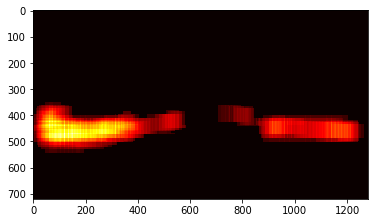

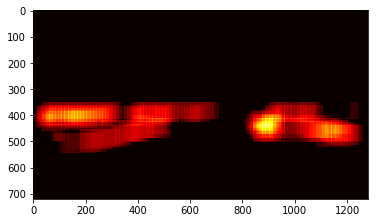

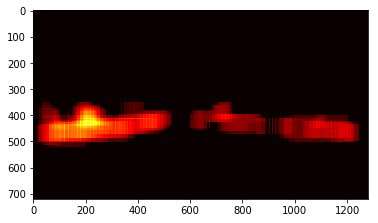

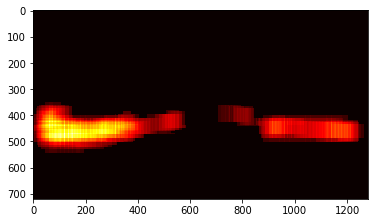

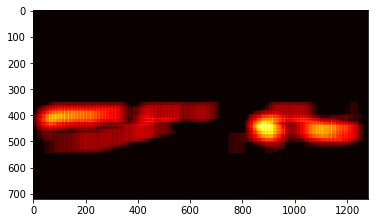

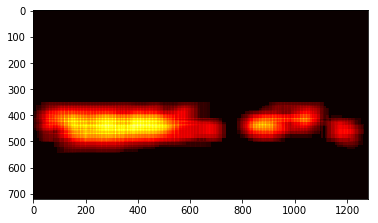

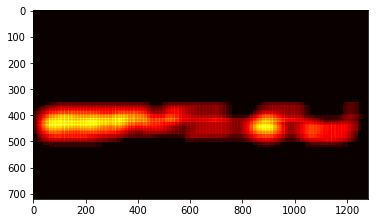

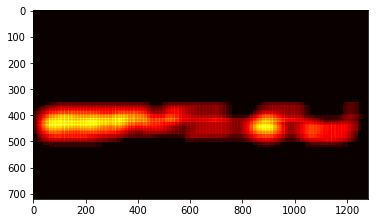

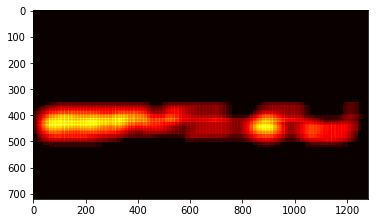

In [127]:
totheat=np.zeros_like(temp_detector.current_heat)
for heats in temp_detector.heatmaps:
    totheat += heats
    plt.imshow(heats,cmap='hot')
    plt.figure()

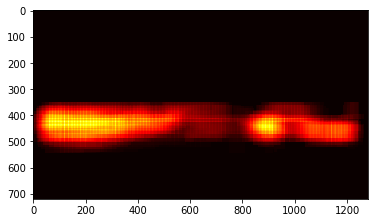

In [129]:
plt.imshow(totheat,cmap='hot')

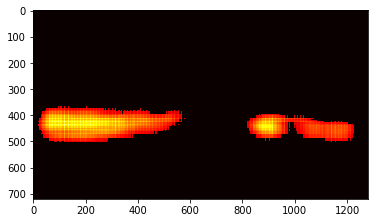

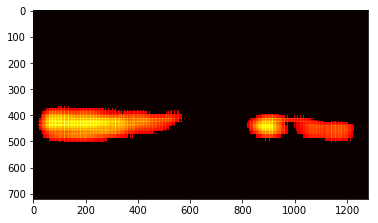

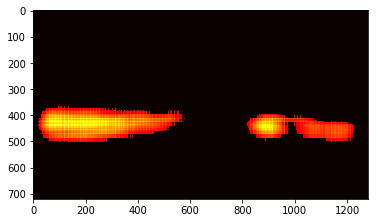

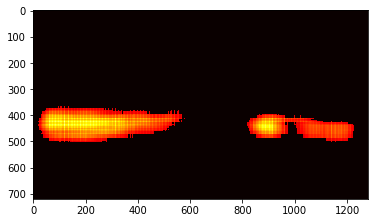

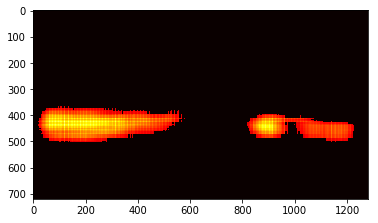

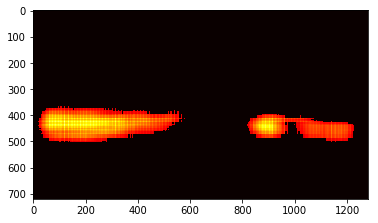

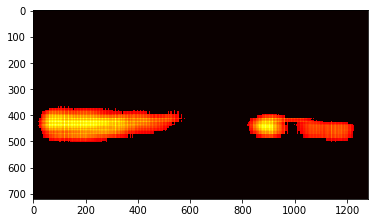

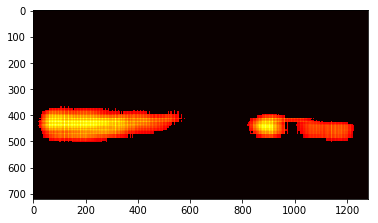

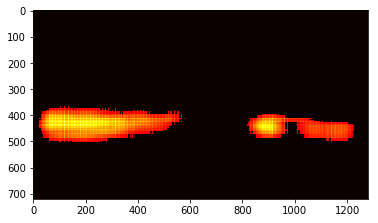

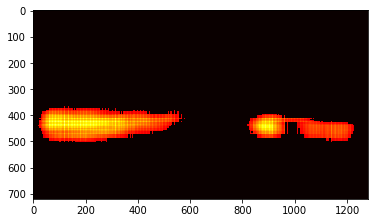

In [135]:
heat = apply_threshold(totheat,150)

In [47]:
def process_image(image):
    temp_detector.process_current(image)
    temp_detector.update_heat()
    if(len(temp_detector.heatmaps)==temp_detector.frame_window):
        temp_detector.sum_heatmaps()
    else:
        temp_detector.out_image=temp_detector.input_img
    return temp_detector.out_image
    

13
14
15
15
15
15


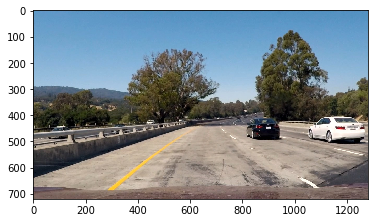

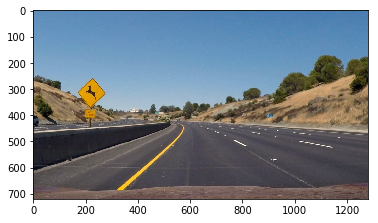

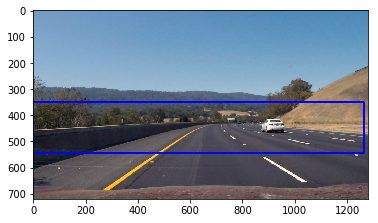

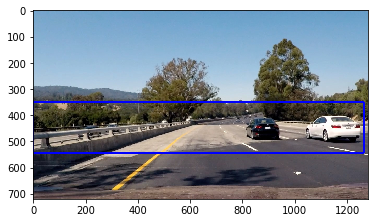

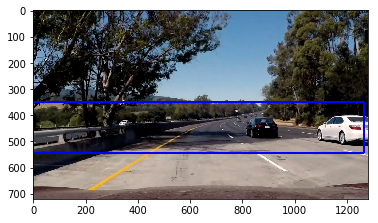

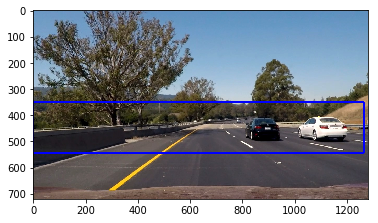

In [155]:
# temp_detector = VDetector()
for image in test_images:
    process_image(mpimg.imread(image))
    plt.figure()
    plt.imshow(temp_detector.out_image)
    print(len(temp_detector.heatmaps))

In [149]:
print(len(temp_detector.heatmaps))

0


In [157]:
#instantiate the VDetector object
temp_detector = VDetector()
sample_output = 'vid_out_pipeline.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)


[MoviePy] >>>> Building video vid_out_pipeline.mp4
[MoviePy] Writing video vid_out_pipeline.mp4


100%|█████████▉| 1260/1261 [5:29:27<00:13, 13.24s/it]     


[MoviePy] Done.
[MoviePy] >>>> Video ready: vid_out_pipeline.mp4 

CPU times: user 3h 48min 36s, sys: 2min 21s, total: 3h 50min 58s
Wall time: 5h 29min 28s


In [162]:
#instantiate the VDetector object
temp_detector = VDetector()
temp_detector.frame_window=3
sample_output = 'vid_out_pipeline_3filter.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)


[MoviePy] >>>> Building video vid_out_pipeline_3filter.mp4
[MoviePy] Writing video vid_out_pipeline_3filter.mp4



 24%|██▍       | 303/1261 [07:28<24:07,  1.51s/it]


 48%|████▊     | 605/1261 [15:03<16:22,  1.50s/it]


 72%|███████▏  | 907/1261 [22:38<09:17,  1.58s/it]


 96%|█████████▌| 1205/1261 [30:10<01:26,  1.54s/it]


100%|█████████▉| 1260/1261 [31:34<00:01,  1.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vid_out_pipeline_3filter.mp4 

CPU times: user 31min 3s, sys: 28.7 s, total: 31min 31s
Wall time: 31min 35s


In [161]:
#instantiate the VDetector object
temp_detector = VDetector()
temp_detector.frame_window=30
sample_output = 'vid_out_pipeline_30filter.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)


[MoviePy] >>>> Building video vid_out_pipeline_30filter.mp4
[MoviePy] Writing video vid_out_pipeline_30filter.mp4



 24%|██▍       | 303/1261 [07:37<24:37,  1.54s/it]


 48%|████▊     | 605/1261 [15:22<16:44,  1.53s/it]


 72%|███████▏  | 907/1261 [23:06<09:10,  1.55s/it]


 96%|█████████▌| 1205/1261 [30:50<01:27,  1.57s/it]


100%|█████████▉| 1260/1261 [32:15<00:01,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vid_out_pipeline_30filter.mp4 

CPU times: user 31min 42s, sys: 29.7 s, total: 32min 12s
Wall time: 32min 16s


Test hog-only and HLS

In [136]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [None, None] # Min and max in y to search in slide_window()
y_start_stop = [400, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

X_train_temp, X_test_temp, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100)

X_scaler = StandardScaler().fit(X_train_temp)

X_train = X_scaler.transform(X_train_temp)
X_test = X_scaler.transform(X_test_temp)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# param_grid = {}
svc = LinearSVC(C=1.0)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 11 orientations 16 pixels per cell and 4 cells per block
Feature vector length: 528
3.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9707


In [135]:
from sklearn.externals import joblib
joblib.dump(svc, 'dump_svc_hls.pkl') 
joblib.dump(X_scaler, 'dump_scaler_hls.pkl') 

# svc = joblib.load('dump_svc_hog.pkl')
# X_scaler = joblib.load('dump_scaler_hog.pkl')



['dump_scaler_hls.pkl']

In [137]:
# def pipeline_detect(input_image, y_start_stop = [400, None], 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.75),
#                     threshold_flag=False,
#                     color_space='HLS', 
#                     spatial_size=(16, 16), hist_bins=16, 
#                     hist_range=(0, 256), orient=11, 
#                     pix_per_cell=16, cell_per_block=4, 
#                     hog_channel='ALL', spatial_feat=False, 
#                     hist_feat=False, hog_feat=True,
#                     scaler=X_scaler, clf=svc,
#                     debug_mode='off'):
#     #     image = mpimg.imread('test_images/test4.jpg')
#     draw_image = np.copy(input_image)

#     # Uncomment the following line if you extracted training
#     # data from .png images (scaled 0 to 1 by mpimg) and the
#     # image you are searching is a .jpg (scaled 0 to 255)
#     # image = image.astype(np.float32)/255
#     windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
#                         xy_window=xy_window, xy_overlap=xy_overlap)

#     hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)                       
#     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

#     box_list = hot_windows

#     # Read in image similar to one shown above 
#     heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

#     # Add heat to each box in box list
#     heat = add_heat(heat,box_list)
#     # Apply threshold to help remove false positives
#     if (threshold_flag==True):
#         heat = apply_threshold(heat,2)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)
    
#     labels = label(heat)
#     draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
#     if (debug_mode=='debug'):
#         plt.figure()
#         plt.title('Example [400 550], scale = 1')

#         plt.imshow(draw_img)
    
#     heatmap1 = heat
    
    
#     #iterate 3
#     windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, 550], 
#                             xy_window = [int(float(xy_window[0]) * 1.6) , int(float(xy_window[1]*1.6))]
#                            , xy_overlap=[0.5,0.75])

#     hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)                       
#     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

#     box_list = hot_windows

#     # Read in image similar to one shown above 
#     heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

#     # Add heat to each box in box list
#     heat = add_heat(heat,box_list)
#     # Apply threshold to help remove false positives
#     if (threshold_flag==True):
#         heat = apply_threshold(heat,2)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)
    
#     labels = label(heat)    
#     draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
#     if (debug_mode=='debug'):
#         print( int(float(xy_window[0]) * 1.6))
#         plt.figure()
#         plt.imshow(draw_img)
#         plt.title('Example [500 650], scale = 1.6')

#     heatmap3 = heat

    
    
    
#     #iterate 4
#     windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, 600], 
#                         xy_window=[int(float(xy_window[0]) * 2.1) , int(float(xy_window[1]*2.1))]  , xy_overlap=[0.5,0.75])

#     hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)                       
#     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

#     box_list = hot_windows

#     # Read in image similar to one shown above 
#     heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

#     # Add heat to each box in box list
#     heat = add_heat(heat,box_list)
#     # Apply threshold to help remove false positives
#     if (threshold_flag==True):
#         heat = apply_threshold(heat,2)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)
#     labels = label(heat)
    
#     draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
#     if (debug_mode=='debug'):
#         print(int(float(xy_window[0]) * 2.1))
#         plt.figure()
#         plt.imshow(draw_img)
#         plt.title('Example [400 600], scale = 2.1')

#     heatmap4 = heat
    

    
#     #iterate 5
#     windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, 650], 
#                         xy_window=[xy_window[0] * 3, xy_window[1]*3]  , xy_overlap=[0.5,0.75])

#     hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)                       
#     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

#     box_list = hot_windows

#     # Read in image similar to one shown above 
#     heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

#     # Add heat to each box in box list
#     heat = add_heat(heat,box_list)
#     # Apply threshold to help remove false positives
#     if (threshold_flag==True):
#         heat = apply_threshold(heat,2)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)
#     labels = label(heat)
    
#     draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
#     if (debug_mode=='debug'):
#         print([xy_window[0] * 3, xy_window[1]*3])
#         plt.figure()
#         plt.imshow(draw_img)
#         plt.title('Example [450 650], scale = 3')

#     heatmap5 = heat    

#     heat = heatmap1 + heatmap3 +  heatmap4 + heatmap5
#     heat = apply_threshold(heat,1)

#     labels = label(heat)
#     draw_img = draw_labeled_bboxes(np.copy(input_image), labels)



#     return draw_img,heat, labels

In [144]:
def pipeline_detect(input_image, y_start_stop = [400, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.75),
                    threshold_flag=False,
                    color_space='HLS', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=11, 
                    pix_per_cell=16, cell_per_block=4, 
                    hog_channel='ALL', spatial_feat=False, 
                    hist_feat=False, hog_feat=True,
                    scaler=X_scaler, clf=svc,
                    debug_mode='off'):
    #     image = mpimg.imread('test_images/test4.jpg')
    draw_image = np.copy(input_image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # image = image.astype(np.float32)/255
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                        xy_window=xy_window, xy_overlap=[0.75,0.85])

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    if (debug_mode=='debug'):
        plt.figure()
        plt.title('Example [400 550], scale = 1')

        plt.imshow(draw_img)
    
    heatmap1 = heat
    
    
    #iterate 3
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                            xy_window = [int(float(xy_window[0]) * 1.6) , int(float(xy_window[1]*1.6))]
                           , xy_overlap=[0.75,0.85])

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heat)    
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    if (debug_mode=='debug'):
        print( int(float(xy_window[0]) * 1.6))
        plt.figure()
        plt.imshow(draw_img)
        plt.title('Example [500 650], scale = 1.6')

    heatmap3 = heat

    
    
    
    #iterate 4
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                        xy_window=[int(float(xy_window[0]) * 2.1) , int(float(xy_window[1]*2.1))]  , xy_overlap=[0.75,0.85])

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heat)
    
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    if (debug_mode=='debug'):
        print(int(float(xy_window[0]) * 2.1))
        plt.figure()
        plt.imshow(draw_img)
        plt.title('Example [400 600], scale = 2.1')

    heatmap4 = heat
    

    
    #iterate 5
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, 650], 
                        xy_window=[xy_window[0] * 3, xy_window[1]*3]  , xy_overlap=[0.75,0.85])

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    box_list = hot_windows

    # Read in image similar to one shown above 
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    if (threshold_flag==True):
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heat)
    
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)
    if (debug_mode=='debug'):
        print([xy_window[0] * 3, xy_window[1]*3])
        plt.figure()
        plt.imshow(draw_img)
        plt.title('Example [450 650], scale = 3')

    heatmap5 = heat    

    heat = heatmap1 + heatmap3 +  heatmap4 + heatmap5
    heat = apply_threshold(heat,1)

    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(input_image), labels)



    return draw_img,heat, labels

In [145]:
class VDetector():
    def __init__(self):
        self.out_image = None
        # transformation matrix, will be used for birds-eye-view transformation
        self.svc = svc
        # inverse transformation matrix, will be used for transforming lanes from birds-eye-view to normal view
        self.xscaler = X_scaler
        # the current unprocessed image
        self.heatmaps=[]
        
        self.current_img = None
        self.current_heat = None
        self.current_labels = None
        self.debug_mode = 'off'
        self.frame_window = 15
        self.input_img = None
        self.total_heat = None
        self.total_labels = None
    #get left and right line curvature and update the radius_of_curvature attribute of the left and right lines
    def process_current(self,input_img):
        self.current_img, self.current_heat, self.current_labels = pipeline_detect(input_image=input_img, \
                            y_start_stop = [400, None], \
                            xy_window=(64, 64), xy_overlap=[0.85, 0.85],\
                            threshold_flag=False,\
                            color_space='HLS', \
                            spatial_size=(16, 16), hist_bins=16, \
                            hist_range=(0, 256), orient=11, \
                            pix_per_cell=16, cell_per_block=4, \
                            hog_channel='ALL', spatial_feat=False, \
                            hist_feat=False, hog_feat=True,\
                            scaler=X_scaler, clf=svc,\
                            debug_mode=self.debug_mode)
        self.input_img=input_img
        
    def update_heat(self):
        if (len(self.heatmaps)==self.frame_window):
            self.heatmaps.pop(0)
        self.heatmaps.append(self.current_heat)
    def sum_heatmaps(self):
        totheat=np.zeros_like(temp_detector.current_heat)
        for heats in self.heatmaps:
            totheat += heats
            
        heat = apply_threshold(totheat,i)
        self.total_heat = heat
        labels = label(self.total_heat)
        self.total_labels = labels
        draw_img = draw_labeled_bboxes(np.copy(self.input_img), labels)
        self.out_image = draw_img
        

In [146]:
def process_image(image):
    temp_detector.process_current(image)
    temp_detector.update_heat()
    if(len(temp_detector.heatmaps)==temp_detector.frame_window):
        temp_detector.sum_heatmaps()
    else:
        temp_detector.out_image=temp_detector.input_img
    return temp_detector.out_image
            
temp_detector = VDetector()

test_images/test1.jpg
102
134
[192, 192]
test_images/test2.jpg
102
134
[192, 192]
test_images/test3.jpg
102
134
[192, 192]
test_images/test4.jpg
102
134
[192, 192]
test_images/test5.jpg
102
134
[192, 192]
test_images/test6.jpg
102
134
[192, 192]


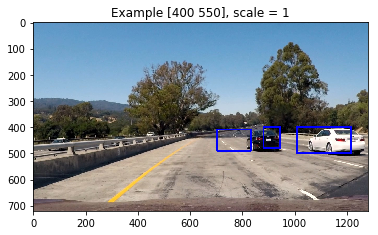

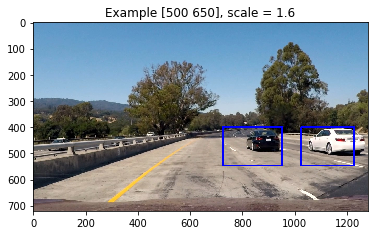

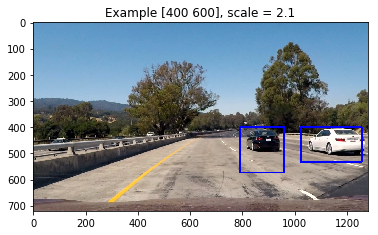

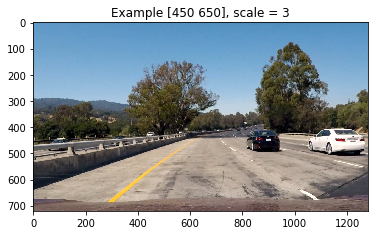

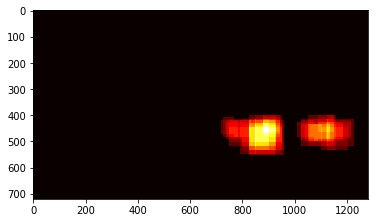

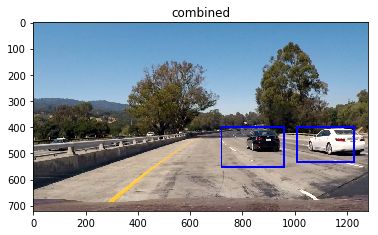

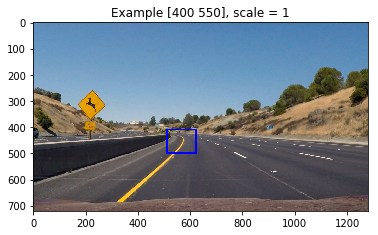

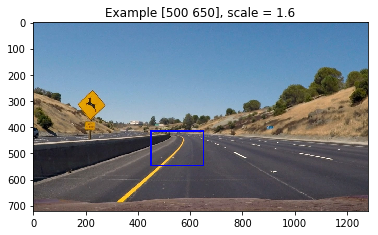

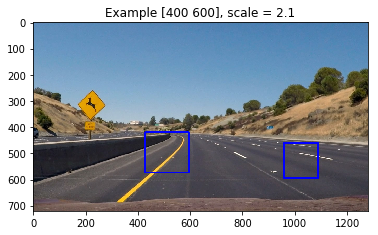

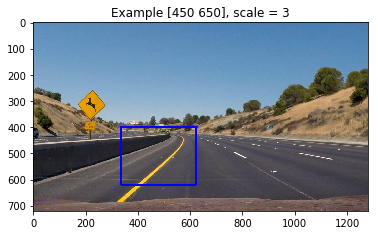

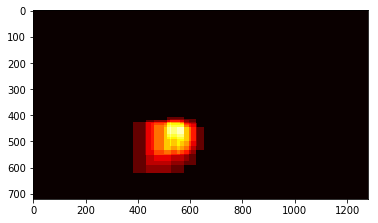

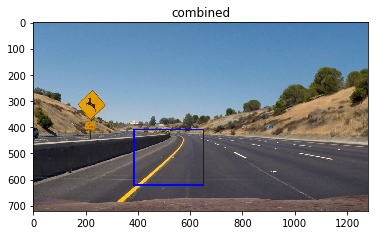

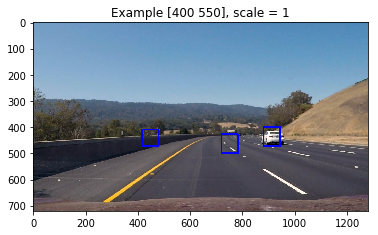

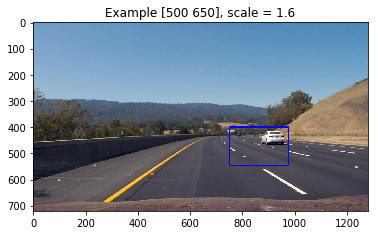

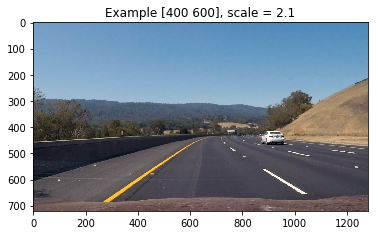

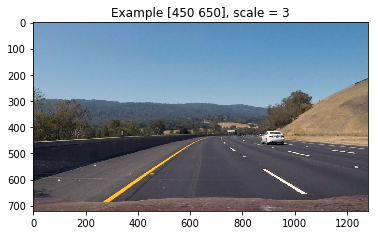

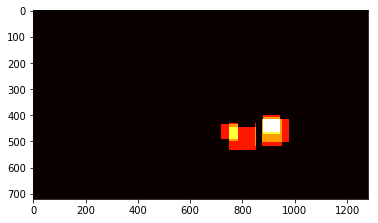

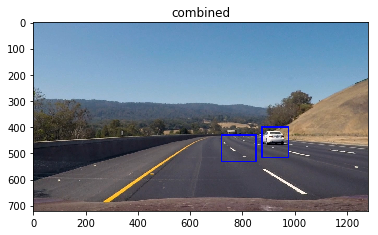

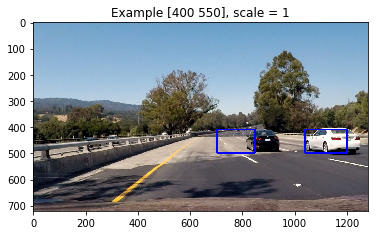

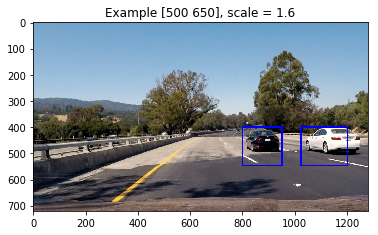

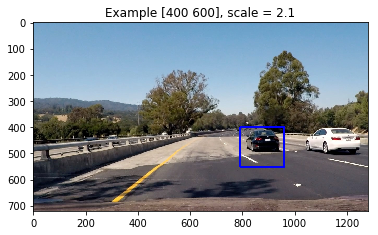

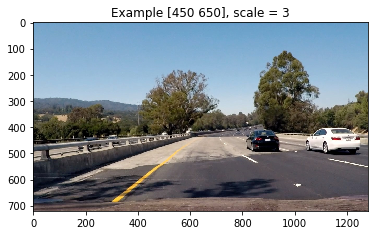

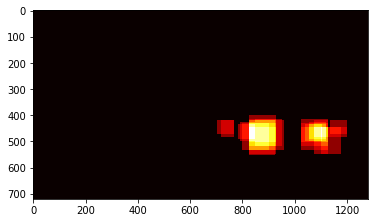

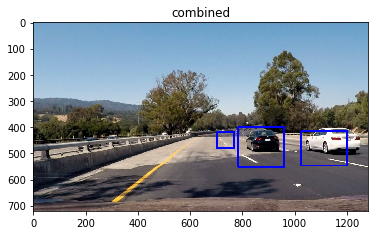

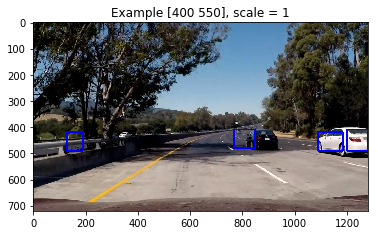

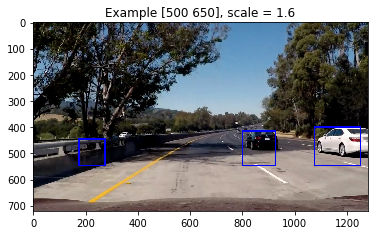

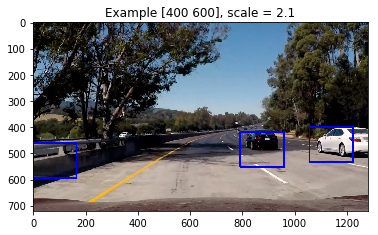

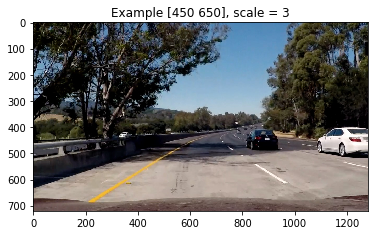

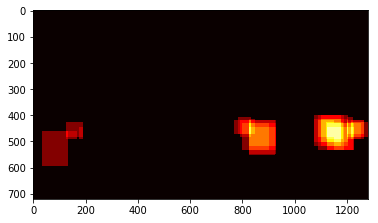

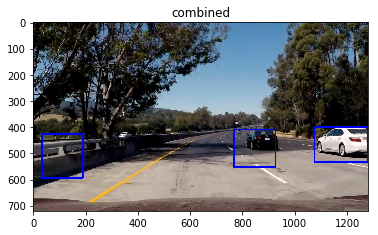

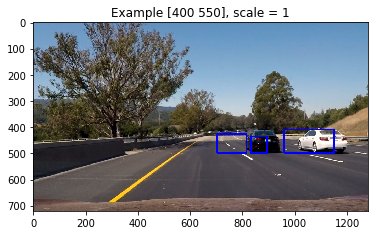

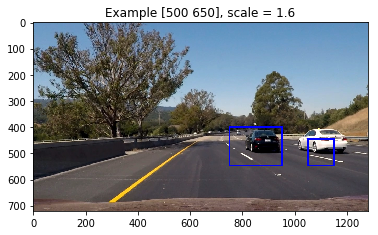

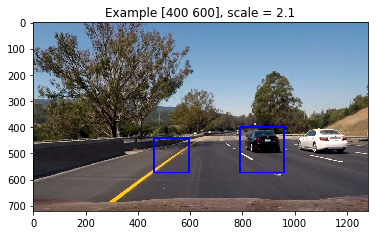

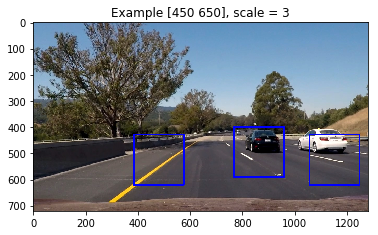

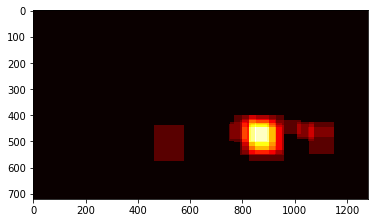

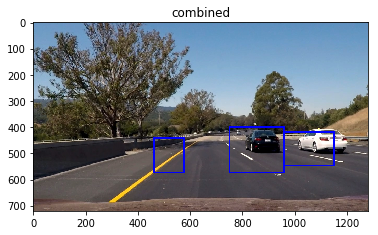

In [147]:
for i in range(0,len(test_images)):
    print(test_images[i])
    input_img = mpimg.imread(test_images[i])
    drawn_img,heatmap_img,labels = pipeline_detect(input_image=input_img, y_start_stop = [400, None],
                        xy_window=(64, 64), xy_overlap=(0.85, 0.85),
                        threshold_flag=False,
                        color_space='HLS', 
                        spatial_size=(16, 16), hist_bins=16, 
                        hist_range=(0, 256), orient=11, 
                        pix_per_cell=16, cell_per_block=4, 
                        hog_channel='ALL', spatial_feat=False, 
                        hist_feat=False, hog_feat=True,
                        scaler=X_scaler, clf=svc,
                        debug_mode='debug')
    plt.figure()
    plt.imshow(heatmap_img, cmap='hot')

    # plt.figure()
    # plt.imshow(labels, cmap='hot')
    # plt.imshow(temp_img)
    plt.figure()
    plt.imshow(drawn_img)
    plt.title('combined')

In [ ]:
#instantiate the VDetector object
temp_detector = VDetector()
temp_detector.frame_window=5
sample_output = 'temp_out3.mp4'
clip1 = VideoFileClip("bridgeshadowhw.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)


[MoviePy] >>>> Building video temp_out3.mp4
[MoviePy] Writing video temp_out3.mp4


 45%|████▌     | 108/238 [03:59<04:50,  2.24s/it]